# Dog Breeding Identification Project

---

Sources:

- Precision and Recall article at [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

- 20 Popular Machine Learning Metrics at [Towards Data Science](https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce)

- notes from Udacity Data Science Nanodegree classroom

First, import libraries:

In [82]:
import dogbreed as dog
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

from glob import glob
from matplotlib.cbook import boxplot_stats
from time import time

sns.set_style("whitegrid")
random.seed(8675309)

Evolving a **count files** function:

- first base was taken from [Stack Overflow](https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python):

In [83]:
#########1#########2#########3#########4#########5#########6#########7#########8
def count_files(path):
    '''This function returns the counting for all valid files from a given 
    directory.
    
    Input:
      - path (mandatory) - the full path for our focused directory - 
        (Text String) 
      
    Output:
      - the number of valid files at this directory (Integer)     
    '''
    count = len([1 for x in list(os.scandir(path)) if x.is_file()])
    
    return count

Testing it:

- we already manually counted the valid files at **home** directory

In [84]:
count_files('.')

11

Evolving a `os.walk` function to run over files in directories:

- first base code can be found at [QA Stack](https://qastack.com.br/programming/16953842/using-os-walk-to-recursively-traverse-directories-in-python)

Now, adapting and co-evolving both functions...

I could produce this `count_files` over here:

- first version, can navigate through directories and **print** the counts for valid files at each one;

- later added a `suppress` parameter, just to elliminate noise at the beginning of each string containing info about a speficic directory;

- later added a `dic_fold` object, just to return a **dictionnary** for our counts.

Why a **dictionnary**? Just because it is a **harsh table** and it is a very **neat** structure to deal it, adding that it is very fast to **retrieve information** from it!

In [88]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_walk(path,
            suppress=0,
            verbose=False):
    '''
    This function takes a path and makes a count, navigating through
    subdirectories, in search of valid files. This is a good function when you
    have for example, some directories with a bunch of subdirectories, each one
    containing pictures of a specific theme. So, it was designed to opperate over
    a directory tree of 3 deepness levels - first is the base, second is the label
    as subfoldes and the third is the image files.
    
    Inputs:
      - path (mandatory) - the base directory to star your search (Text String)
      - suppress (optional) - the number of initial characters to suppres from
        the keys of the dictionnary (Integer, default=0)
      - verbose (optional) - if you want some verbosity on this function
        (default=False)
        
    Outputs:
      - total - the total number of valid files found in your search (Integer)
      - dic_fold - the subdirectories as keys and the specific countings as 
        Integers
    '''

    total = 0
    dic_fold = {}
    
    if verbose:
        print('###function walk started')
    
    for root, vdir, files in os.walk(path):
        count = count_files(path=root) #calling my function
        
        if count > 0:
            key_fold = root[suppress:]
            if verbose:
                print('{}: {} file(s)'.format(key_fold, count))
            total += count
            dic_fold[key_fold] = count 
        
    return total, dic_fold

Testing it:

In [89]:
path='.'
res, dic_fold = fn_walk(path='.',
                        suppress=2,
                        verbose=True)
print('*found {} files in {}'.format(res, path))

dic_fold

###function walk started
: 11 file(s)
images: 17 file(s)
bottleneck_features: 5 file(s)
haarcascades: 1 file(s)
__pycache__: 2 file(s)
requirements: 8 file(s)
.ipynb_checkpoints: 4 file(s)
saved_models: 5 file(s)
*found 53 files in .


{'': 11,
 'images': 17,
 'bottleneck_features': 5,
 'haarcascades': 1,
 '__pycache__': 2,
 'requirements': 8,
 '.ipynb_checkpoints': 4,
 'saved_models': 5}

---


## Dogs Analysis

The images are in 3 already splitted datasets

- the first one represents 80% of all the pics, and were used for **Train**

- the second, 10% for **Test** and;

- the third one, 10% for **Validation**

As out Perceptron could see only the **first** group for Training, we will focus our statistics on this group.

In [90]:
path = '../../../data/dog_images/train'
res, key_dog = fn_walk(path=path, 
                       suppress=35,
                       verbose=True)
print('*found {} files in {}'.format(res, path))

###function walk started
Mastiff: 58 file(s)
Doberman_pinscher: 47 file(s)
Curly-coated_retriever: 50 file(s)
Borzoi: 56 file(s)
Bichon_frise: 62 file(s)
Chinese_crested: 50 file(s)
Finnish_spitz: 34 file(s)
Welsh_springer_spaniel: 44 file(s)
Bedlington_terrier: 48 file(s)
Papillon: 63 file(s)
Saint_bernard: 30 file(s)
Australian_terrier: 46 file(s)
Parson_russell_terrier: 30 file(s)
Norfolk_terrier: 46 file(s)
Yorkshire_terrier: 30 file(s)
Boston_terrier: 65 file(s)
Norwegian_buhund: 26 file(s)
Bluetick_coonhound: 35 file(s)
Field_spaniel: 33 file(s)
Tibetan_mastiff: 48 file(s)
Alaskan_malamute: 77 file(s)
Manchester_terrier: 29 file(s)
Boxer: 64 file(s)
Flat-coated_retriever: 63 file(s)
Irish_wolfhound: 53 file(s)
Miniature_schnauzer: 42 file(s)
Boykin_spaniel: 53 file(s)
Greater_swiss_mountain_dog: 46 file(s)
American_foxhound: 50 file(s)
Nova_scotia_duck_tolling_retriever: 54 file(s)
Black_and_tan_coonhound: 37 file(s)
German_shorthaired_pointer: 48 file(s)
English_setter: 53 file(

And what I expect? Something like:

- as we have **6680** pics, in a **fair** distribution, we will have near to **50** pics for each dog breed;

- personally I expected a Standard Deviation near to **5%**, so in **rough numbers**, kind of **45** dogs in the smallest group and kind of **55** dogs in the largest group.

In [79]:
6680 / 133

50.225563909774436

Here the magic happens... **describe** method!

In [7]:
df_dogs = pd.DataFrame.from_dict(data=key_dog, 
                                 orient='index', 
                                 columns=['count'])
df_dogs.describe()

,count
count,133.000000
mean,50.225564
std,11.863885
min,26.000000
25%,42.000000
50%,50.000000
75%,61.000000
max,77.000000


We have 77 pics of **Alaska Malamute** and only 26 pics of **Norwegian Buhund**, so:
    
- we have almost **3 times** more pictures from the first breed than the second one;

- the **weakest** group is **24 pics** below our expectation of **50 pics** in mean.

In [80]:
77 / 26

2.9615384615384617

What to say about **Dog Pics** data?

- It is a **high biased** data, as our Perceptron will train **much better** for recognizing an **Alaska Malamute** than a **Norwegian Buhund**!

---

#### Critics about this data

- The main metric that we are using in this project is **Accuracy**;

- and Accuracy is **very sensible** to **imbalanced class distributions**;

There are a lot of critics about using **Accuracy** over **Imbalanced Data**. At Towards Data Science article (refered in the beginning of this paper), clearly it says about **Precision**: (**bold** parts are mine annotations)

*"There are many cases in which classification accuracy is **not a good indicator** of your model performance. One of these scenarios is when your class distribution is **imbalanced** (one class is more frequent than others). In this case, even if you predict all samples as the most frequent class you would get a high accuracy rate, which does not make sense at all (because your model is not learning anything, and is just predicting everything as the top class)"*

For me, it is a good explanation of why to in general, avoid **imbalanced data** for training classes:

- basically you are training a Perceptron to be so speciallized on **Alaska Malamute** doggos. And then, even the teeths, or the whiskers of this big dog breed will be well-understood by our Perceptron artificial neurons;

- it is a kind of the problem to having a **dog kennel** in hour house. And then taking someone to take a look for your precious dogs. And of course, you don´t have all the **dog breeds** in the planet. And this guy will learn everything about some kinds of dogs. But when he moves into another kennel, in another house, he will turn really confused, about **new breeds**, and new ways to grow them, and everything;

- what to do? We could just delete the extra files for taking a **more balanced** dataset. It have a cost, as we will have less pictures to show to our Perceptron. Or we could try other metrics. **Towards Data Science** article says, for in these cases, try **Precision** metrics. So we could start trying other metrics for this data.

---

Plotting some graphs about **dogs dataset**:

- Boxplots from data [here](https://stackoverflow.com/questions/33518472/how-to-get-boxplot-data-for-matplotlib-boxplots)

- using Seaborn [documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

I choose for a first view, **Boxplot**. Why? Just because this Pandas `describe` method gives us a good **number** insights about our data.

But, when you see the box, and the whiskers, things goes much clearer! And a good add for Boxplot normally is **Swarmplot**. So, if plots are kind of **bees**, with a Swarmplot, I can have a visual insight of how the **beehive** is structured:

- for example, if I have kind of a **central aggregation**, and then some kind of **local nucleous**, on one, or both whiskers;

- if the whiskers are so **assymetrical** or not;

- something about our **outliers**.

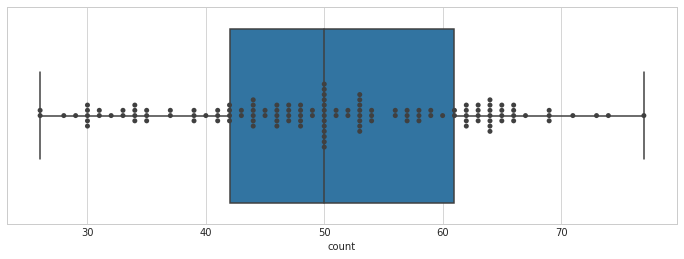

In [8]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="count", 
            ax=ax, 
            data=df_dogs)
sns.swarmplot(x="count", 
              data=df_dogs, 
              color=".25");

Another fun plotting to use is **Countplot**.

- Seaborn gives us a really **neat** visuallisation;

- It was a good experience to use some kind of structure that is similar to Pandas behavior, just to **plot** graphs.

I can see, for example:
    
- by the countings, what is the **frequency** for each one;

- I can see a lot of countings with exactly **50** pictures inside, and this is really **nice**;

- I can also see a spreading of other countings, going from, let me say, 1-4 countings in a spred, going form **26** through **77** pics on each one - so in a spread of differences of **51**;

- and also, considering **more than 4**, this range compresses not so much, going from **30** through **60** - so in a spread of differences of **30**.

So, to correct these data, it could be suggested to:

1. Take the counts for **50+** and try to not gather more data on these dog breeds;

2. take the counts **lesser than 50** and try to add more pics for these breeds!

*I already know that a perfect balanced dataset is **pratically impossible**! But the worst problem here is not showing **too much** for example, **Alaska Malamute** pics to our Perceptron, but to show **so few** pics form for example, **Norwegian Buhund** breed, so our Perceptron cannot learn about the essential pattern to recognize this kind of dogs!*

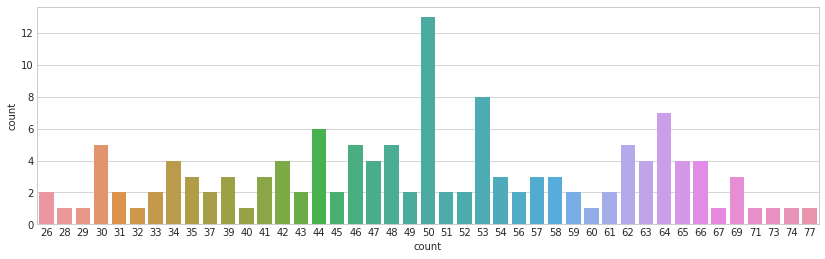

In [23]:
fig_dims = (14, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x=df_dogs['count'])

---

## For humans

Now I have a **much larger** dataset, with about 13233 pics, spraded in 5749 individuals:

- I have nothing as a kind of **human breed** in this data. What I have now is distinct human beings;

- what I expect from this data? Roughly **2-3 pictures** from each one of this individuals. 

In [45]:
path_h = '../../../data/lfw'
tot, key_human = fn_walk(path=path, 
                         suppress=18,
                         verbose=True)
print('*found {} files in {}'.format(tot, path_h))

Dan_Ackroyd: 1 file(s)
Alex_Corretja: 1 file(s)
Daniele_Bergamin: 1 file(s)
Donald_Carty: 1 file(s)
Barry_Switzer: 1 file(s)
Jeong_Se-hyun: 9 file(s)
Ellen_Engleman: 2 file(s)
Peter_Lundgren: 1 file(s)
Stephen_Thompson: 1 file(s)
Hernan_Crespo: 1 file(s)
Marquier_Montano_Contreras: 1 file(s)
Adriana_Lima: 1 file(s)
Penny_Dupuie: 1 file(s)
Jimmy_Kimmel: 2 file(s)
Michael_Clarke_Duncan: 1 file(s)
Jane_Clayson: 1 file(s)
Paul_Celluci: 1 file(s)
Jorge_Valdano: 2 file(s)
Rodolfo_Abalos: 1 file(s)
Paul_Reiser: 1 file(s)
Phil_Bennett: 1 file(s)
Ibrahim_Jaafari: 2 file(s)
Rafael_Vinoly: 1 file(s)
Stuart_Townsend: 1 file(s)
Miranda_Otto: 1 file(s)
Michael_Kahn: 1 file(s)
Linus_Roache: 1 file(s)
Michael_Guiler: 1 file(s)
Julianne_Moore: 19 file(s)
Jake_Gyllenhaal: 5 file(s)
Satnarine_Sharma: 1 file(s)
Miguel_Angel_Rodriguez: 1 file(s)
Nick_Price: 1 file(s)
Tony_Parker: 2 file(s)
Janusz_Kaminski: 1 file(s)
James_Layug: 1 file(s)
Rohinton_Mistry: 1 file(s)
Mike_Myers: 7 file(s)
Paddy_Long: 1 file(

OK, I can se in **Describe**, that:
    
- my **mean** was **2.3**, so, as much as I expected;

- for my **whikers**, I have **1** picture for 25% quartile, and this is not a surprise;

- and for 75% quartile, I took a **2** pictures, what is quite a bit lower than I expected (perhaps I would find there **4** pictures, and not only **2**!);

- and a kind of a **giant outlier** there, with **530** pics!

In [47]:
df_humans = pd.DataFrame.from_dict(data=key_human, 
                                   orient='index', 
                                   columns=['count'])
df_humans.describe()

,count
count,5749.000000
mean,2.301792
std,9.016410
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,530.000000


**High biased data**, as there is a guy there, to be trained **230 times** our average, for his face!

In [58]:
530 / 2.301792

230.2553836315358

Our **Boxplot** turned so **biased** by some outliers, that is quite impossible to take a good view of it:

- why to not just **remove** the outliers, and re-plot the Boxplot? Just because if we do this, we are **lying** about our statistics. As we already **trained** our Percetron in a so **biased** way!

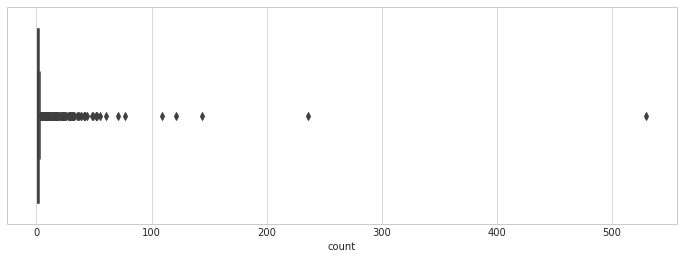

In [51]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="count", 
            ax=ax, 
            data=df_humans);

Adding **Swarmplot** shows how some **individuals** distorted our data:

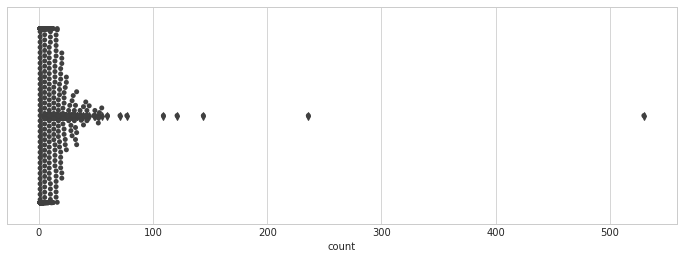

In [48]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="count", 
            ax=ax, 
            data=df_humans)
#don´t run it, it is so long to process!
#sns.swarmplot(x="count", 
#              data=df_humans, 
#              color=".25");

Another way to see it, is looking at **Countplot**:
    
- we can see **4000+** individuals trained under **1** pic and then;

- kind of **750** individuals traindes under **2** pics;

- decreasing really **fast**, until **5** pics, and then came these outliers.

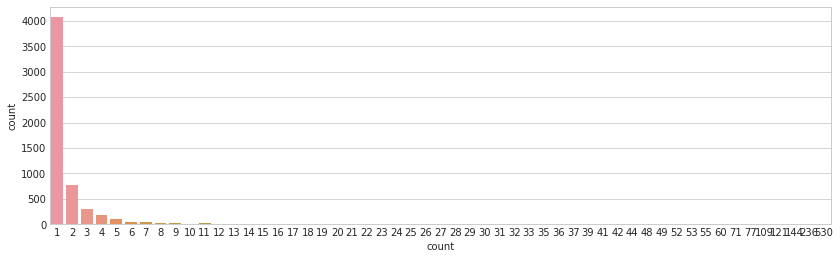

In [49]:
fig_dims = (14, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x=df_humans['count'])

About the outliers:
    
- I tried to filter the amount of pics, to get kind of **1%** of the **most-pics outliers**;

- So, with **20+** pics, I could isolate the 57 outliers that appeared there;

- the names of some of the **most notable** outliers are:

  - George W Bush (530)
  
  - Colin Powell (236)
  
  - Tony Blair (144)
  
  - etc..
  
- other **strange names**, that took my attention, let me see:

  - Saddam Hussein (23)
  
  - Arnold Schwarzenegger (42)
  
  - Bill Clinton (only 29!)
  
*So, a comment: if I want to make an **archeological study** about when this data was collected, I can do it, based in the **frequency** of pics of some public faces that were catalogued here!*

In [64]:
print('length:', len(df_humans[df_humans['count']>20]))
df_humans[df_humans['count']>20]

length: 57


,count
Jose_Maria_Aznar,23
Winona_Ryder,24
Serena_Williams,52
Tom_Daschle,25
Arnold_Schwarzenegger,42
Mahmoud_Abbas,29
Ariel_Sharon,77
Laura_Bush,41
Hugo_Chavez,71
Rudolph_Giuliani,26


A **very exclusive** group:

Roughly, people with **more than 20 pictures** in the dataset, are represented by a group of **1% of the total people** in the dataset!

In [63]:
100 * (57 / 5749)

0.9914767785701861

And pictures from them represent as to **22% of the total of pics** in the dataset!

In [75]:
100 * (df_humans[df_humans['count']>20].sum() / 13233)

count    22.088718
dtype: float64

 we see that the dataset is highly imbalanced, with the majority of people having 1 to 9 images. Let's get rid of this majority so that we can better view the rest of the dataset.
 
 Clearly, we have a lot of images some specific people.

---

## Project Definition

### Overview of the Project

### The Problem Involved

###  Some Metrics About it

## Data Analysis

### Exploring the Data

### Visualizing the Data

## Methodology

### Preprocessing the Data


### Implementing and Coding

### Refining the Algorithms

## Results

### Evaluating and Validating the Model

### Justifying what is done

## Conclusion

### Reflection

### Potential things to Improve



### Project Overview

The main idea to this project is to have contact with **Perceptrons** technology.

The theoretical concepts involved in **Perceptrons** are not so new. I fact, **Frank Rosenblatt** was evolving that was known as the **first** Perceptron in the history, in 1958, for military applications (source, [Wikipedia](https://en.wikipedia.org/wiki/Perceptron)).

With the evolving of computers, specially **GPUs** (Graphic Processor Units), the search for machineas that could emulate the working of a **neuron** was intensified. The proposal is, with **minimal** human intervention, to train a machine that can make tasks involving **Classification** or **Fitting Curves** at least so well as humans can do. Perceptrons evolved in a way that they proved to be a great alternative for some kinds of problems, as **Image Classification**.

The task proposed by **Udacity** as Capstone for **Data Science Nanodegree** was to make some experimentation involving **Perceptrons**. Perceptrons are also known as a **Deep Learning Technique**, what means that it involve more than one layer of learning.

Udacity provided for this project, a **Jupyter Notebook** and **Extra Classes** as part of the learning process. The programming language involved is **Python**, and also some specific libraries, as **Pandas** (for dataframes opperations), **Keras** (for Deep Learning machines), and **Numpy** (for mathematica/geometrical operations), just to cite some of them.

### Problem Statement

The scope of the project is to Train/Test Perceptrons for **Face Recognition** and test the possibility to transform them to **Dog Recognition**. Later, to train them for **Dog Breed Recognition**. And finally, creating a general Perceptron for, given an image, telling it there was a **human** there, or a **dog**, or neither a **human or dog**. And as an add, if a **human** face was found, to give a guess, if it was a **dog**, what dog breed is more similar to it.

---
[a brief outline of the steps that you'll take to solve the problem. In other words, you should briefly mention the preprocessing, deep learning, and refinement approaches that you'll use to address the problem]
---

Udacity metodology is strongly inspired by the formula **DCR** (**Drive, Correct, Repeat**). This small acronym refers for the learning process involved in training a new car driver:

> - first, the instructor gives you some **orientation** about safety rules and the tasks you will need to do, and then letting you to try by yourself (**Drive**);
> - second, you will be **corrected** from your mistakes and how to avoid them. If is necessary, new explanations will be given for a better drive experience (**Correct**);
> - third, you will be oriented to try again, and again, until you achieve the necessary **expertise** for driving a car by yourself (**Repeat**).

As an **analogy** to learning how to drive a car, some explanation is given in an **incomplete** Jupyter Notebook. Explanatory notes will be found in all your learning process. And if you stuck in some point, you can as for **Mentor** help. I made it a lot of times. And having a **Mentor** (not quite a **Mentat**, like you can see in this Sci-Fi movie **Dune** - 2021) is really a good thing, when you are lost in a forest of **Coding** trees!

### Metrics

The project metric was **Accuracy**. Data was splitted into **Train**, **Validation** and **Testing**, for avoid contamination of the Perceptron metrics. The **Test Accuracy** is the main metric for this project.

---
[explain or justify why accuracy is an optimal metric for this dataset. Why did you choose it instead of other common classification metrics like precision, recall, F1 etc.? Hint: accuracy only works well when the dataset classes are balanced...would that be the case here?]
---

### Data Exploration

The main data source for this project is **OpenCVs Implementation of Haar Feature-based Cascade Classifiers** for face recognition. In our Jupyter Notebook, it corresponds to:

- Step 1: Detect Humans

- Step 2: Detect Dogs

---
[Features and calculated statistics relevant to the problem have been reported and discussed related to the dataset, and a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.]
---

### Data Visualization

---

[present it in the writeup]

---

My input data is faces and dogs images, in **.jpg** files, in size 224x224, RGB. To visuallize them, I just load the pictures that I need to visuallize in my Jupyter Notebook, using:

`pic_link = '/home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg'`

`img = load_img(pic_link, target_size=(224, 224))`

`img`

### Data Preprocessing

Some techniques were used to preprocess my images files, as:

- transforming them fom RGB to **Greyscale**;

- resizing them to **224x224** pixels, when it is necessary;

- transforming them into a **4D Tensor**, just to feed our **Perceptron**.

*Observation: **Image Augmentation** was not tried in this project!*

[All preprocessing steps have been clearly documented. Abnormalities or characteristics about the data or input that needed to be addressed have been corrected. If no data preprocessing is necessary, it has been clearly justified.]

### Implementation

[explain all the key details that someone would need to understand and reproduce your results. Key items like the hyper parameter settings, architecture etc. are fully documented. You should also be sure to note if there were any complications or difficulties that you encountered during the coding process]

- first, was tested a **face recognition** pre-trained Perceptron for a **human face** dataset;
 
- then, was tested a **dog recoginition** pre-trained Perceptron for a **dog** dataset;

- then, was crossed over **face recognition** with a **dog** dataset and;

- **dog recognition with a **human face** dataset.

The idea as to give a basic prime of **False Negatives** and **False Positives** in pre-trained Perceptrons.

### Refinement

- first was created **by-zero** a Perceptron, using Keras library. The perceptron was trained for dog breeding recognition;

- next, was tested Perceptrons created using pre-trained Bottlenecks. The idea is to implement a Percetron using pre-trained first layers, with very accurate patterns, by exaustive training. What is expected is that using pre-trained Bottlenecks in some cases, can improve a lot our **Accuracy**.

[The process of improving upon the algorithms and techniques used is clearly documented. Both the initial and final solutions are reported, along with intermediate solutions]

Then parameters were changed, using a `charge` function. Metrics were evaluated for each change, until we attained a reasonable Accuracy.

### Model Evaluation and Validation

The final model, an hybrid between a loaded Bottleneck was runned for Epochs to fit for our purpose of **dog breeding** identification. The original Bottleneck was pre-trained for **human face recognition**. Model was evaluated for **Accuracy** on Test dataset, with pictures never used in earlier phases of the process.

[If a model is used, the following should hold: The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution. For example, you can use cross-validation to find the best parameters. Show and compare the results using different models, parameters, or techniques in tabular forms or charts. Alternatively, a student may choose to answer questions with data visualizations or other means that don't involve machine learning if a different approach best helps them address their question(s) of interest.]

### Justification

Our best trained Perceptron attained as **75%** Accuracy. It is not so nice for professional projects, but we can use it for having some fun on **Dog Breed Classification**.

One picture of a dog was tested, sucessfully in the Jupyter Notebook. Then we could implement the **last phase** of the project, that is to given an image, says if there is a dog, or human in this image, and say if it is a human, the most likely **dog breed**, if it was a **dog**.

[The final results are discussed in detail. Explain the exploration as to why some techniques worked better than others, or how improvements were made are documented.]

### Reflection

It is not a so-deep project, as the main objective of this **Data Science Nanodegree** is not to train Perceptrons. For having some fun about how Perceptrons work, it is OK. We also not deal with **images** in my job.

[Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.]

### Improvement

A lot of parameters were **not** tested in the Perceptrons that I used in my project. For example, I could explore better:

- changing the **Padding**;

- changing the **pool_size**;

- creating a **pre processing** phase, including **image augmentation**;

- adding one more **Dense** layer at the end of my Perceptron.

*Last note: I nearly **exausted** the GPU time, on Udacity workspace. Perhaps I will need more GPU time for doing more testings on these parameters. Perceptrons are a bit **complex**, so there are a lot of parameters to test!* 

[Discussion is made as to how at least one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.]

---

## Parts of the project

#### Step 0: Import Datasets

Also I needed to import my libraries and was asked to create/evolve some predefine **functions** for making everything running well. It was not so hard!

#### Step 1: Detect Humans

The idea was to use as base a OpenCV (a public domain face detector) and a bunch of pre-loaded data. And then was invited to create my own **Human Face Dectector**, giving a picture do say if a human was there or not.

#### Step 2: Detect Dogs

As this is a project for **Dog Breeding Detection**, the next step was to make the same thing, involving now images and evolving a pre-trained **Dog Detector**. The involved technology for both detectors was **CNN** (**Convolutional Neural Networks**). Pre-processing phases involved turning a Image into a Tensor, evolving functions to turn this step easier. Predictions were made using a pre-trained CNN named **ResNet-50**. Then I was invited to write my own **Dog Detector**.

#### Step 3: Create a CNN from Zero

In this phase, I was asked to create my own **CNN** to classify **Dog Breeds**. In this time, from Scratch. That means that I will not be using third-part ready-made technology. I needed to crate my own **Architecture** and was asked for **at least 1%** of Accuracy on the **Test** dataframe. It sounds as a **easy** task, but it is not so! Some dog breads are some similar from one to another that it is really **hard**, even for me, to tell exactly what the breed is, giving a picture.

Some adjustments were suggested (my first **Accuracy** was only 0,93%), like to add **Dropout** Layers, for preventing **Overfitting** during the Train phase. To determine the best number of **Epochs** (machine states, that creates a model to be evaluated), mas for me, a bit **challenging**. My best Accuracy was near to **12%**. Not so bad, for a written from zero model!

#### Step 4: Use a CNN to Classify Dog Breeds

The idea in this step was to use pre-trained **Bottlenecks** and then just adding new layers form zero, to be trained. It sounds as a **strange** idea, as we were using first Perceptron Layers trained for other uses (as detecting **Human**) faces for a dog-detection task, but it makes some sense:

>- general patterns are **universal**, so the first layers of a Perceptron could detect, by long training, to capture skin texture, background differentiation, horizontal and vertical lines, etc..

>- pictures containing **faces**, being from a human, or a dog, have some similarities. As the general shape, the contrast between the face-area and the background, etc..

>- a so-well trained **Bottleneck** was evolved so much, trained with hundreds of thousands of images, even **millions** of images, that the captured patterns are really reliable!

I was asked to complete the Model Architecture, adding some Layers by myself. This demmanded a bit of **study** of what these Layers could do for me, the **dimmensions** involved, and a lot of **parameters** to set. The model was then compiled, trained and checked for Accuracy on the **Test** Dataframe. Some **Dog Breeds** were predicted with the new Model, now with a Test Accuracy near to **40%**.

#### Step 5: Create a CNN to Classify Dog Breeds

This time the tactic evolved to using **Transfer Learning**. The expected Accuracy was at least **60%** at the Test Dataframe. We were invited to experiment with some Bottlenecks available in Keras (some of them earned very **notable** prizes!). Whe could use things like VGG-19, ResNet-50, etc..

I obtained some of these Bottlenecks (not all of them, as we had limited **GPU Time** and Storage Capacity on Udacity servers). Then, I created a Function for making adjustments and iterating with my chosen Bottlenecks (**ResNet-50** and **InceptionV3**). After a quite hard job, I could at the same time, evolve a better **Tester/Feeder** Function, that I named **The Charger**, and obtain the best parameters that I could find for attaining near to **75%** of Accuracy on Test Dataframe. Not bad at all!

For **fun** I took one picture of myself and tested on my already trained Classifier. And if I was a dog, my breed should be **Silky Terrier**! Oh, it was a really **good momen** for a joke!

#### Step 6: Write your Algorithm

The idea now is to create a Application by myself. So, taken a pre-trained Classifier and some pictures in **public domain** and the ones already preexistent in a Udacity folder to say:

>- if there is a **dog** in the picture;
>- if there is a **human** in the picture;
>- if a **human** was found, what it will be his most likely **dog breed** it it was a **dog**;
>- give error warnings, if something went wrong.

#### Step 7: Test your Algorithm

1. every **dog** I tested, from Udacity folder, was recognized as a dog and **only** as a dog (not a human). Nice;

2. some of the "humans" that I tested form free domain images, were tested as **humans** (Einstein picture, Mr Spock from Star Treck, Roland Macdonalds and even Fofão - a man dressed as a dog, very famous in Brazillian culture). They also passed in the test to **not** being a dog, and received some (only for **humor**!) dog breeds tags if they were dogs, what breed they could be;

3. two of the "humans" didn´t pass in the **human** test. One was a picture from **Werewolf**, a 1995 movie and for (**obvious**!) reasons, the monster was **not** interpreted as a human! The other one was my own picture and the most likely reason is that it is a so **distorted** pic, taken with my old webcam, and so **badly** reshaped for 224x224 image that the Perceptron could not recognize it as a human. OK, I can pass with this idea!  